In [1]:
%matplotlib inline

import time
import dataset as dc
import sys
import os
import matplotlib.pyplot as plt
import torch.optim as optim
import gstools as gs

from gstools.random import MasterRNG
from torchsummary import summary
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.metrics import accuracy_score, classification_report

#sys.path.append("../../CNN_model/")
#from skip import *
from model import *
from train import *
from utils import *
from dataset import *
from parameter import *

In [2]:
######  Check CUP or GPU  ######
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
print(device)

cuda


 maximum value of true model:  tensor(5.6949, device='cuda:0')


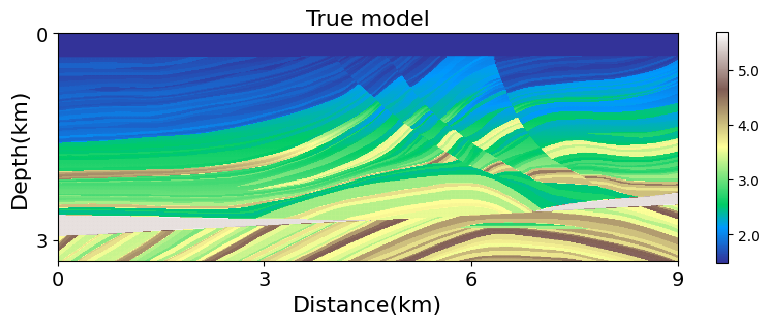

In [3]:
### Load true velocity model  ###
model_true = (np.fromfile(Inputfile_path + Inputfile_name, np.float32).reshape(nz,nx))
#model_true = np.transpose(model_true,(1,0)) # I prefer having depth direction first
model_true = torch.Tensor(model_true).to(device)   # Convert to a PyTorch Tensor
print(' maximum value of true model: ', model_true.max())

m_vmin, m_vmax = (
    model_true.detach().cpu().numpy().min(),
    model_true.detach().cpu().numpy().max(),
)

x = torch.arange(0, nx)
z = torch.arange(0, nz)

# create mask for water layer
msk = mask(model_true, water_velocity=1.5, device=device)

# plot the real model
fig = plt.figure(figsize=(10,4))

plt.imshow(model_true.cpu().numpy(), 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain', interpolation='none',            
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]])
# plt.axis("scaled")
plt.title('True model',fontsize=16)
plt.xticks([0,200,400,600],[0,3,6,9])
plt.yticks([0,200],[0,3])
plt.xlabel('Distance(km)',fontsize=16)
plt.ylabel('Depth(km)',fontsize=16)
colorbar = plt.colorbar(shrink=0.75)
colorbar.set_ticks(np.linspace(2, 5, 4))  # Example ticks
colorbar.set_ticklabels(['2.0', '3.0', '4.0', '5.0'])  # Example labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Change the font size of major ticks
plt.savefig( Figurepath + 'real_model.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# Show the figure
plt.show()

Loaded model from ./data/deterministic_fwi_result.npy


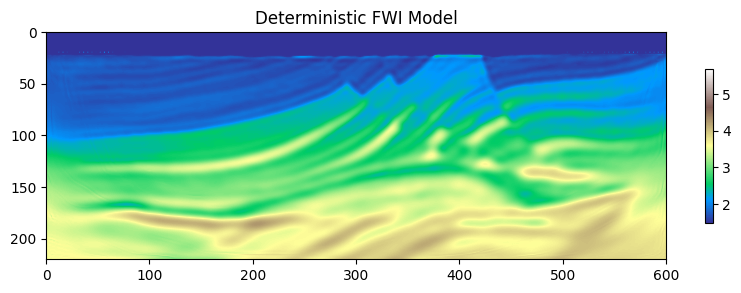

In [4]:
# load the deterministic optimization results
model_fwi = np.load(f"{fwi_model_path}")
print(f"Loaded model from {fwi_model_path}")

plt.figure(figsize=(10, 4))
# plot the deterministic optimization results
plt.imshow(model_fwi, 
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
           extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]]
                   )
plt.title('Deterministic FWI Model')
plt.colorbar(shrink=0.5)

In [5]:
# ADD GRF Term
rf = gs.Matern(dim=2, var=2.5e-2, len_scale=5, nu=1.25)
srf = gs.SRF(rf)
srf.set_pos([z, x], "structured")

grf_seed = MasterRNG(20170590)
for i in range(num_particles):
    srf(seed=grf_seed(), store=f"better_field{i}")

# generate initial model
grf = torch.from_numpy(np.array(srf)).float().reshape(num_particles, -1)
X_init = torch.from_numpy(model_fwi)
X_init = X_init.reshape(1, -1).repeat(num_particles, 1)
X_init = (X_init + grf).to(device)

with torch.no_grad():
    X_init = X_init * msk.reshape(1, -1)
    X_init[:, model_true.ravel() <= 1.5] = 1.5
    initial_particles = X_init.clone().detach().cpu().numpy()
    X_init.clamp_(m_vmin, m_vmax)
X_init.requires_grad = True

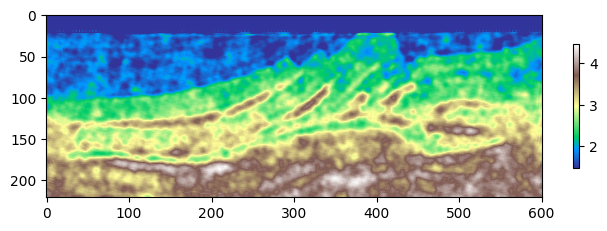

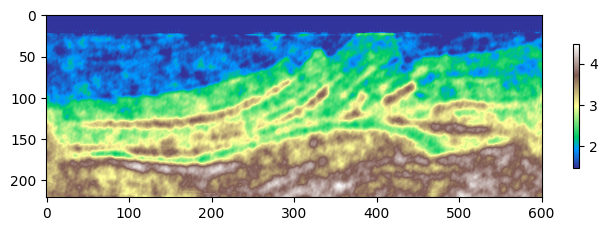

In [6]:
# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(X_init[0,:].detach().cpu().numpy().reshape(nz,nx),
            cmap="terrain",
            )
plt.colorbar(shrink=0.4)

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(X_init[1,:].detach().cpu().numpy().reshape(nz,nx),
            cmap="terrain",
            )
plt.colorbar(shrink=0.4)

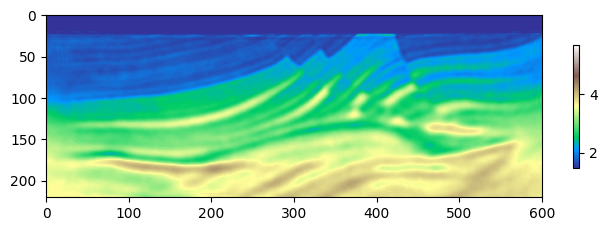

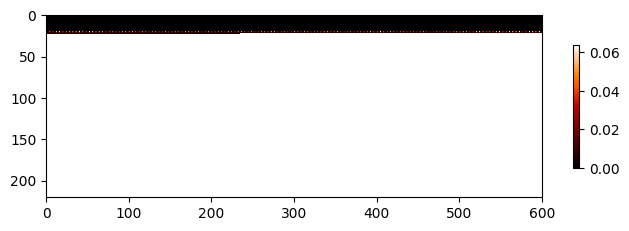

In [7]:
mean_init = X_init.detach().clone().cpu().numpy().mean(0)
std_init  = X_init.detach().clone().cpu().numpy().std(0)

plt.figure(figsize=(8,4))
plt.imshow(mean_init.reshape(nz,nx),
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
            interpolation="bilinear",
            extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]])
plt.colorbar(shrink=0.4)

plt.figure(figsize=(8,4))
plt.imshow(std_init.reshape(nz,nx),
        cmap="gist_heat", 
        vmin=0,
        vmax=0.064,
        extent=[x[0], 
                x[-1], 
                z[-1], 
                z[0]]
        )
plt.colorbar(shrink=0.4)

In [8]:
arr_nonzero = np.where(std_init == 0, np.inf, std_init)
nonzero_min = np.min(arr_nonzero)
print(nonzero_min)

0.064953595


### Begin training

In [9]:
# define model
input_channel  = 1
output_channel = 1
n_condition    = num_particles
n_feat   = 512
n_cfeat  = num_particles
model = CONTEXT_UNET(in_channels=input_channel, out_channels=output_channel, n_feat=n_feat, n_cfeat=n_cfeat, feature=[8, 16, 32, 64, 128]).to(device)

In [10]:
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  2059337


In [11]:
# Push the data forward through the model layers
data1  = torch.randn([1, 1, nz, nx]).to(device)
random_permutation = torch.arange(0,num_particles)
data2  = torch.eye(num_particles)[:, random_permutation].to(device)
output = model(data1, data2[0])
print(output.shape)

torch.Size([1, 1, 221, 601])


In [12]:
data1  = torch.zeros([1, input_channel, nz, nx]).to(device)
data1_saved = data1
noise_saved = data1
random_permutation = torch.arange(0,num_particles)
data2  = torch.eye(num_particles)[:, random_permutation].to(device)

## Begin Training

data1  = torch.randn([1, 1, nz, nx]).to(device)
data1_saved = data1

random_permutation = torch.arange(0,num_particles)
data2  = torch.eye(num_particles)[:, random_permutation].to(device)

In [13]:
# randomly mask out c
c=torch.tensor([[1],[0]]).to(device)
context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.5).to(device)
c = c * context_mask.unsqueeze(-1)
print(c)

tensor([[0.],
        [0.]], device='cuda:0')


In [14]:
def train(model, device, optimizer,loss_criteria):
    # Set the model to training mode
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx in range (1):
        for condition in range (num_particles):
            # Use the CPU or GPU as appropriate
            data1_input = data1_saved + noise_saved.uniform_()*1/10
            data2_input = data2[condition].reshape([1,num_particles])

            # context_mask = torch.bernoulli(torch.zeros(data2_input.shape[0]) + 0.9).to(device)
            # data2_input = data2_input * context_mask.unsqueeze(-1)

            # target = define_label(random_permutation).view(1,num_particles,cfg.params.nz,cfg.params.nx).to(device)
            target =  X_init[condition,:].view(1,1,nz,nx).to(device)
            
            # Reset the optimizer
            optimizer.zero_grad()
            
            # Push the data forward through the model layers
            output = model(data1_input, data2_input)
            
            # Get the loss
            loss = loss_criteria(output, target)
            
            # Keep a running total
            train_loss += loss.item()
            
            # Backpropagate
            loss.backward()
            optimizer.step()
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    return avg_loss

In [15]:

log_prior = None
optimizer = torch.optim.Adam(
    [{"params": model.parameters(), "lr": learning_rate, "weight_decay":weight_decay}]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, nepoch + 1, 0
)

# Specify the loss criteria
loss_criteria = torch.nn.MSELoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []
pre_loss=100

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = pretrain_num_iter
loop_batch = tqdm(range(0, pretrain_num_iter, 1), leave=True)
for epoch in loop_batch:
        train_loss = train(model, device, optimizer,loss_criteria)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        
        pre_loss = training_loss[epoch-1]
        #print(pre_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

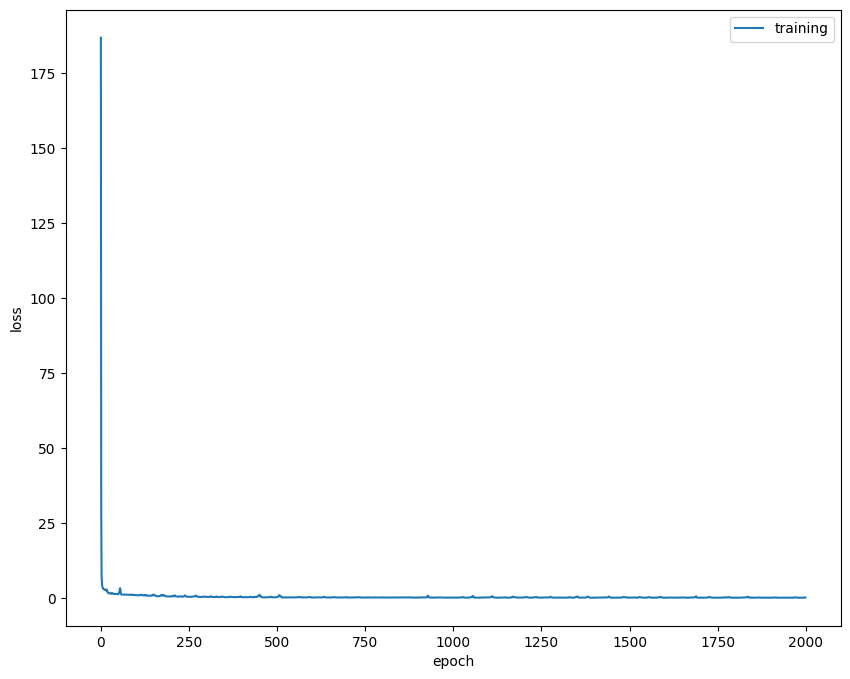

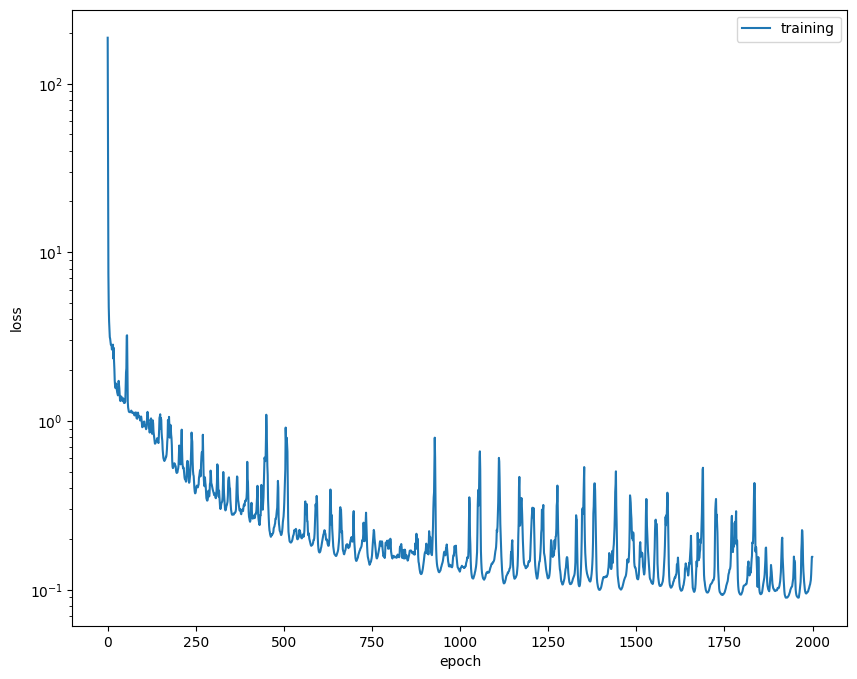

In [16]:
fig = plt.figure(figsize=(10,8))

plt.plot(epoch_nums, training_loss)
#plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

fig = plt.figure(figsize=(10,8))

plt.semilogy(epoch_nums, training_loss)
#plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

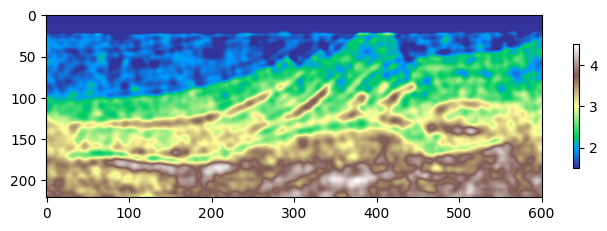

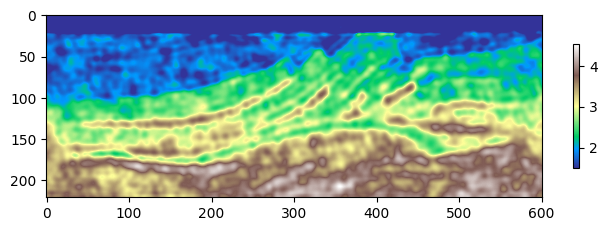

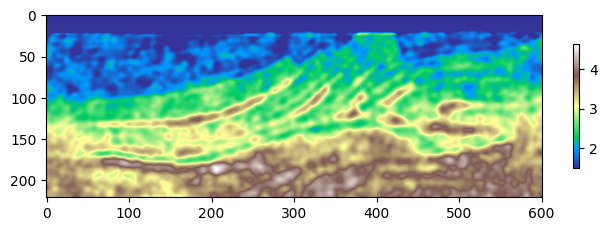

In [17]:
data1 = data1_saved.to(device)
data2  = torch.eye(num_particles).to(device)

output1=model(data1,data2[0])
output2=model(data1,data2[1])
output3=model(data1,data2[-1])

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(output1.detach().cpu().numpy().reshape(nz,nx),
            cmap="terrain",
            )
plt.colorbar(shrink=0.4)

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(output2.detach().cpu().numpy().reshape(nz,nx),
            cmap="terrain",
            )
plt.colorbar(shrink=0.4)

# model1 plot
plt.figure(figsize=(8,4))
plt.imshow(output3.detach().cpu().numpy().reshape(nz,nx),
            cmap="terrain",
            )
plt.colorbar(shrink=0.4)

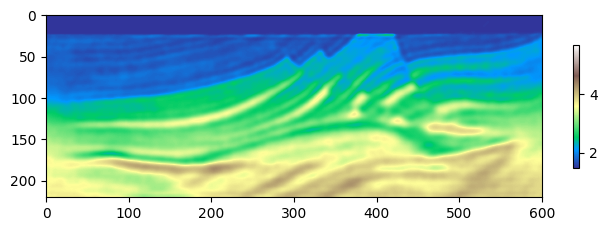

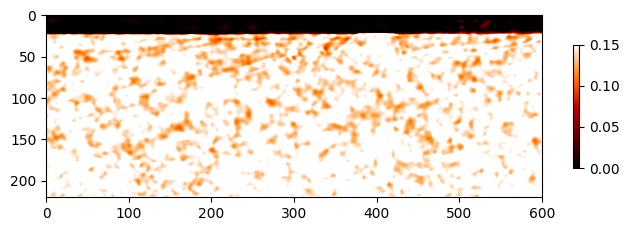

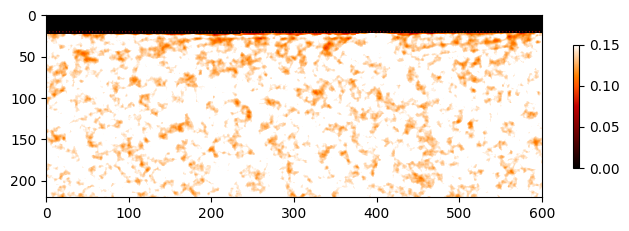

In [18]:
data1 = data1_saved.to(device)
data2  = torch.eye(num_particles).to(device)
model_output =[]

for i in range (num_particles):
    output=model(data1,data2[i])
    model_output.append(output.detach().clone().cpu().numpy()) 

total = np.array(model_output).reshape(num_particles,-1)
total_1 = torch.tensor(total)

mean_output = total_1.view(num_particles,-1).detach().clone().cpu().numpy().mean(0)
std_output  = total_1.view(num_particles,-1).detach().clone().cpu().numpy().std(0)

plt.figure(figsize=(8,4))
plt.imshow(mean_output.reshape(nz,nx),
           vmin=m_vmin, 
           vmax=m_vmax, 
           cmap='terrain',
            interpolation="bilinear",
            extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]])
plt.colorbar(shrink=0.4)

plt.figure(figsize=(8,4))
plt.imshow(std_output.reshape(nz,nx),
        cmap="gist_heat", 
        vmin=0,
        vmax=0.15,
        extent=[x[0], 
                x[-1], 
                z[-1], 
                z[0]]
        )
plt.colorbar(shrink=0.4)

plt.figure(figsize=(8,4))
plt.imshow(std_init.reshape(nz,nx),
        cmap="gist_heat", 
        vmin=0,
        vmax=0.15,
        extent=[x[0], 
                x[-1], 
                z[-1], 
                z[0]]
        )
plt.colorbar(shrink=0.4)

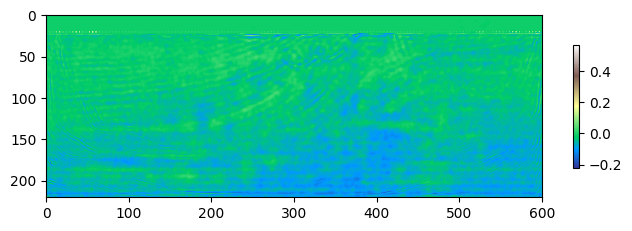

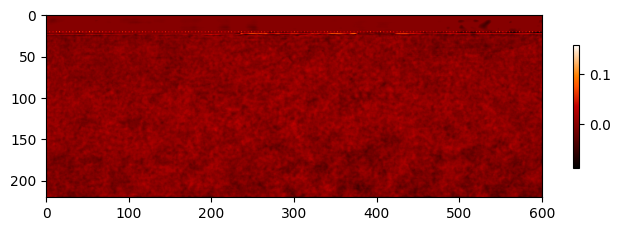

In [19]:
mean_diff = mean_init - mean_output
std_diff  = std_init  - std_output

plt.figure(figsize=(8,4))
plt.imshow(mean_diff.reshape(nz,nx),
           cmap='terrain',
            interpolation="bilinear",
            extent=[x[0], 
                   x[-1], 
                   z[-1], 
                   z[0]])
plt.colorbar(shrink=0.4)

plt.figure(figsize=(8,4))
plt.imshow(std_diff.reshape(nz,nx),
        cmap="gist_heat", 
        extent=[x[0], 
                x[-1], 
                z[-1], 
                z[0]]
        )
plt.colorbar(shrink=0.4)

In [20]:
### save the pretrained network
state = {'ite': pretrain_num_iter,
         'state_dict': model.state_dict(),
         'optim': optimizer,
        }                        
torch.save(state, cnnmodel_path+str(pretrain_num_iter) + ".pth.tar") 